<a href="https://colab.research.google.com/github/louiscam/systemic-activation/blob/main/systemic_activation_tests_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up environment

In [ ]:
# Install relevant packages
Sys.setenv(PATH= paste("/conda/bin" , Sys.getenv("PATH"), sep = ":" ) )
install.packages('welchADF', repos='http://cran.rstudio.com/')
install.packages('dplyr', repos='http://cran.rstudio.com/')
install.packages('tidyverse', repos='http://cran.rstudio.com/')
install.packages('rstatix', repos='http://cran.rstudio.com/')

In [ ]:
# Imports
require(tidyverse)
require(ggplot2)
require(welchADF)
require(rstatix)
require(car)

# Figure **2**

### Load and clean data

Store data in a dataframe and specify two factors: treatment (with three levels: saline, vehicle and rapamycin) and condition (with two levels: amputated and non-amputated).

In [ ]:
# Hard code the data
saline_dat = c(1.328904, 1.190476, 1.005747, 1.960784, 2.053388, 1.243339, 1.22449, 1.552106, 1.361573, 0.451467, 1.769912, 0.64102)
saline_amp_dat = c(3.940217, 4.5, 4.216867, 1.84136, 2.901024, 2.710843, 8.413793, 7.333333, 2.796053, 1.215805)
vehicle_dat = c(0.9375, 0.547945, 0.977654, 0, 1.492537, 2.197802, 2.301255, 2.163062, 0.217391, 0.21978, 1.13852, 0.447094)
vehicle_amp_dat = c(2.828854314, 2.839116719, 5.172413793, 4.990757856, 4.615384615, 2.058823529, 2.452830189, 1.692524683, 1.811125485, 2.18579235)
rapa_dat =  c(0.161031, 1.025641, 0.331675, 0.943396, 0.215983, 0.250627, 0.44843, 0.496689, 0.473934, 1.020408, 0.34662, 0.137552)
rapa_amp_dat = c(0.327869, 0.392927, 0.819672, 0.727273, 0.358423, 0.707965, 0, 0)

In [ ]:
# Create structured dataframe
treatment = c(rep('saline', length(saline_dat)+length(saline_amp_dat)), 
              rep('vehicle', length(vehicle_dat)+length(vehicle_amp_dat)),
              rep('rapa', length(rapa_dat)+length(rapa_amp_dat)))
condition = c(rep('not_amp', length(saline_dat)), rep('amp', length(saline_amp_dat)),
              rep('not_amp', length(vehicle_dat)), rep('amp', length(vehicle_amp_dat)),
              rep('not_amp', length(rapa_dat)), rep('amp', length(rapa_amp_dat)))
y = c(saline_dat, saline_amp_dat,
      vehicle_dat, vehicle_amp_dat,
      rapa_dat, rapa_amp_dat)
systemicActivationData = data.frame(treatment=as.factor(treatment), condition=as.factor(condition), y=y)
systemicActivationData$cell = factor(interaction(systemicActivationData$treatment, systemicActivationData$condition),
                                     levels=c('saline.not_amp', 'saline.amp', 'vehicle.not_amp', 'vehicle.amp', 'rapa.not_amp', 'rapa.amp'), 
                                     ordered=TRUE)

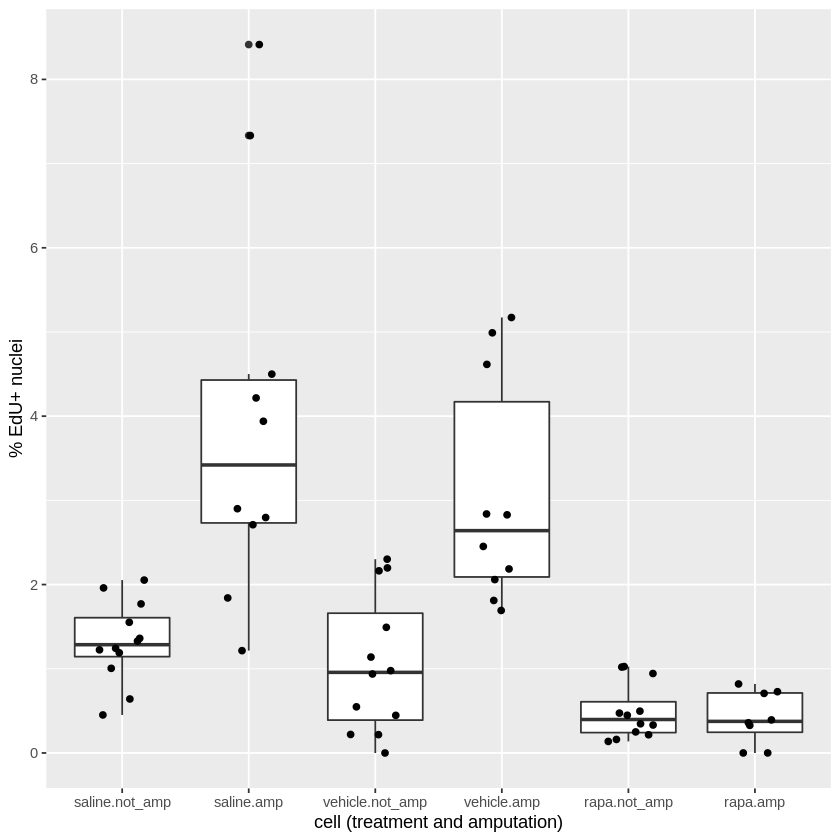

In [ ]:
# Basic data visualization
systemicActivationData %>% 
        ggplot(aes(y=y, x=cell)) +
        geom_boxplot()+
        geom_jitter(width = 0.2) +
        labs(y='% EdU+ nuclei', x='cell (treatment and amputation)')

### Test for normality

Run Shapiro-Wilks test to test for normality of the data in each of the 6 cells of the 3-by-2 two-factor design. Significance is determined at the 0.05 level with Bonferroni correction to control for the Family-Wise Error rate (FWER), i.e. the probability of making one or more false discoveries.

In [ ]:
# Run Shapiro-Wilks test
alpha = 0.05
systemicActivationData %>%
  select(y, cell) %>%
  group_by(cell) %>%
  mutate(z_score=(y-mean(y))/sd(y)) %>%
  shapiro_test(z_score) %>%
  mutate(significant_bonferroni=(p<alpha/length(unique(systemicActivationData$cell))))

cell,variable,statistic,p,significant_bonferroni
<ord>,<chr>,<dbl>,<dbl>,<lgl>
saline.not_amp,z_score,0.9631103,0.82713703,FALSE
saline.amp,z_score,0.8970218,0.20314077,FALSE
vehicle.not_amp,z_score,0.9053808,0.18609459,FALSE
vehicle.amp,z_score,0.8346409,0.03805144,FALSE
rapa.not_amp,z_score,0.8394995,0.02730226,FALSE
rapa.amp,z_score,0.8981494,0.27805054,FALSE


We conclude that the data in each cell is normally distributed.

### Test for homogeneity of variances

Run Levene's test (at the 0.05 level) to test for homogeneity of variances between the 6 cells of the 3-by-2 two-factor design.

In [ ]:
# Run Levene's test
levene = leveneTest(y~cell, data=systemicActivationData, center=mean)
print(levene)

Levene's Test for Homogeneity of Variance (center = mean)
      Df F value    Pr(>F)    
group  5  7.6497 1.411e-05 ***
      58                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


We conclude that the homogeneity of variances property does not hold in this 3-by-2 two-way factor design.

### James-Welch test (omnibus null)

We perform the omnibus James-Welch test (robust 2-way ANOVA), which is protected against unequal variances (by using corrected degrees of freedom when estimating cell standard deviations). This is equivalent to running three unequal variance 1-way ANOVA, one for the two main effects and one for interaction between the factors. Note that this test can also be protected against non-normality using trimming, but we will not use this here since the data passed the Shapiro-Wilks test.

Reference:
Villacorta, P.J., 2017. The welchADF Package for Robust Hypothesis Testing in Unbalanced Multivariate Mixed Models with Heteroscedastic and Non-normal Data. R J., 9(2), p.309.

In [ ]:
# Run James-Welch test for the omnibus null
omnibus_JW = welchADF.test(systemicActivationData, response="y", between.s=c("treatment", "condition"), 
                           contrast = "omnibus", trimming=FALSE, alpha=0.05)
summary(omnibus_JW)

Call:
   welchADF.test(formula = systemicActivationData, response = "y", 
    between.s = c("treatment", "condition"), contrast = "omnibus", 
    trimming = FALSE, alpha = 0.05)

                    WJ statistic Numerator DF Denominator DF   Pr(>WJ)    
treatment                  33.65            2          17.07 1.196e-06 ***
condition                  26.35            1          18.57 6.335e-05 ***
treatment:condition        13.65            2          17.07 2.878e-04 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

We conclude that there exists a significant difference in the cell means for both main effects as well as for the interaction.

### James-Welch test (post-hoc pairwise comparisons)

Since the omnibus test confirms the significance of both main effects and the interaction, pairwise comparisons is conducted on all of them. We will use the post-hoc pairwise James-Welch test to test for all pairwise comparisons of main effects and interactions. We use the Holm-Bonferroni procedure to control the FWER at the 0.05 level.

In [ ]:
# Run James-Welch test for the all pairwise-comparisons for treatment main effect
pairwise_JW = welchADF.test(systemicActivationData, response="y", between.s=c("treatment", "condition"), 
                            contrast = "all.pairwise", effect=c("treatment"),
                            correction='holm', trimming=FALSE, alpha=0.05)
summary(pairwise_JW)

Call:
   welchADF.test(formula = systemicActivationData, response = "y", 
    between.s = c("treatment", "condition"), contrast = "all.pairwise", 
    effect = c("treatment"), correction = "holm", trimming = FALSE, 
    alpha = 0.05)

               WJ statistic Numerator DF Denominator DF  adj.pval    
rapa:vehicle         39.910            1          16.94 2.355e-05 ***
saline:vehicle        1.784            1          17.60 1.986e-01    
rapa:saline          33.930            1          10.42 2.844e-04 ***
---
Signif. codes (Holm p-values):  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

This analysis shows, amon others, that
- there is NO significant difference between the vehicle and saline treatment,
- there is a significant effect of the rapamycin treatment compared to both the vehicle and the saline treatments.

In [ ]:
# Run James-Welch test for the all pairwise-comparisons for interactions
pairwise_JW = welchADF.test(systemicActivationData, response="y", between.s=c("treatment", "condition"), 
                            contrast = "all.pairwise", effect=c("treatment","condition"),
                            correction='holm', trimming=FALSE, alpha=0.05)
summary(pairwise_JW)

Call:
   welchADF.test(formula = systemicActivationData, response = "y", 
    between.s = c("treatment", "condition"), contrast = "all.pairwise", 
    effect = c("treatment", "condition"), correction = "holm", 
    trimming = FALSE, alpha = 0.05)

                             WJ statistic Numerator DF Denominator DF adj.pval
rapa:vehicle x amp:not_amp        16.7553            1          16.94 0.002287
saline:vehicle x amp:not_amp       0.5549            1          17.60 0.466163
rapa:saline x amp:not_amp         13.1957            1          10.42 0.008589
                               
rapa:vehicle x amp:not_amp   **
saline:vehicle x amp:not_amp   
rapa:saline x amp:not_amp    **
---
Signif. codes (Holm p-values):  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

This analysis reveals, among others, that
- the effect of amputation is significantly different depending on whether the subject is treated with rapamycin vs with vehicle
- the effect of amputation is significantly different depending on whether the subject is treated with rapamycin vs with saline
- the effect of amputation is NOT significantly different depending on whether the subject is treated with saline or with vehicle

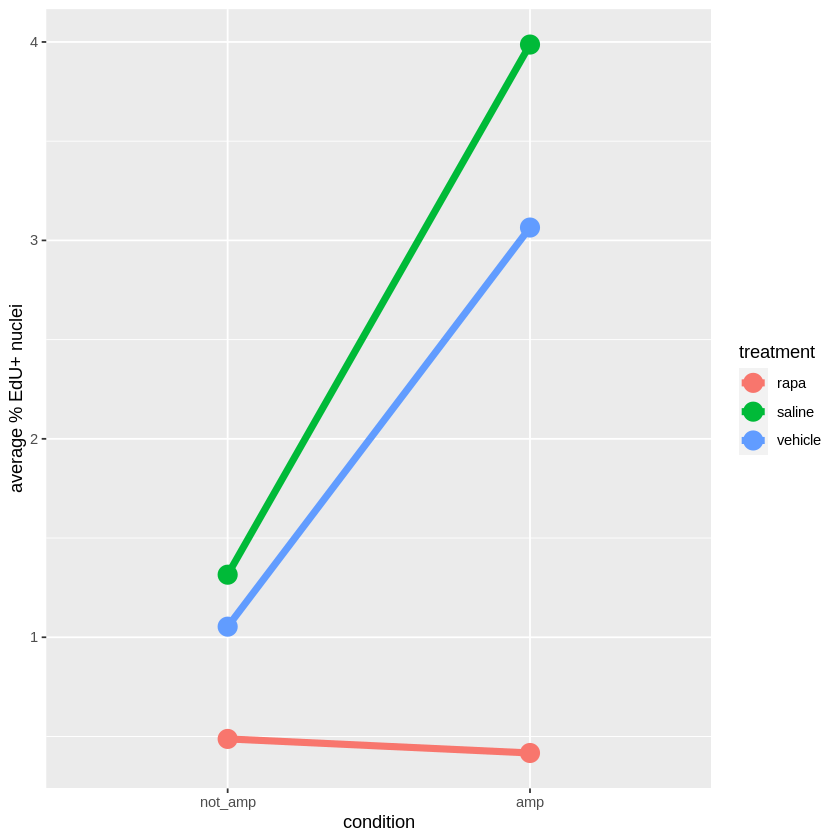

In [ ]:
# Visualize interactions
systemicActivationData %>%
  group_by(treatment, condition) %>%
  summarise(mu=mean(y), .groups='drop') %>%
  group_by(treatment) %>%
  ggplot(aes(x=relevel(condition, 'not_amp'), y=mu, color=treatment))+
  geom_line(aes(group = treatment), size=2)+
  geom_point(size=5)+
  labs(y='average % EdU+ nuclei', x='condition')

# Figure 3

### Load and clean data

Store data in a dataframe and specify two factors: treatment (with two levels: sham and denervated) and condition (with two levels: amputated and non-amputated).

In [ ]:
# Hard code the data
sham_dat = c(0.923, 0.926, 2.744, 1.884, 1.722, 0.951, 1.269, 3.179, 2.138, 1.414, 0.913)
sham_amp_dat = c(7.382, 5.836, 2.329, 9.129, 4.723, 3.52, 2.668, 6.782, 4.934, 8.103, 4.665, 3.306, 2.586)
den_dat = c(5.551, 1.334, 1.003, 1.115, 2.123, 3.01, 10.2, 3.985, 5.367, 0.657)
den_amp_dat = c(1.77, 1.483, 3.14, 2.868, 2, 1.247, 2.156, 0.951, 2.724, 1.151, 1.703, 0.599, 0.49)

In [ ]:
# Create structured dataframe
treatment = c(rep('sham', length(sham_dat)+length(sham_amp_dat)), 
              rep('den', length(den_dat)+length(den_amp_dat)))
condition = c(rep('not_amp', length(sham_dat)), rep('amp', length(sham_amp_dat)),
              rep('not_amp', length(den_dat)), rep('amp', length(den_amp_dat)))
y = c(sham_dat, sham_amp_dat,
      den_dat, den_amp_dat)
systemicActivationData3 = data.frame(treatment=as.factor(treatment), condition=as.factor(condition), y=y)
systemicActivationData3$cell = factor(interaction(systemicActivationData3$treatment, systemicActivationData3$condition),
                                     levels=c('sham.not_amp', 'sham.amp', 'den.not_amp', 'den.amp'), 
                                     ordered=TRUE)

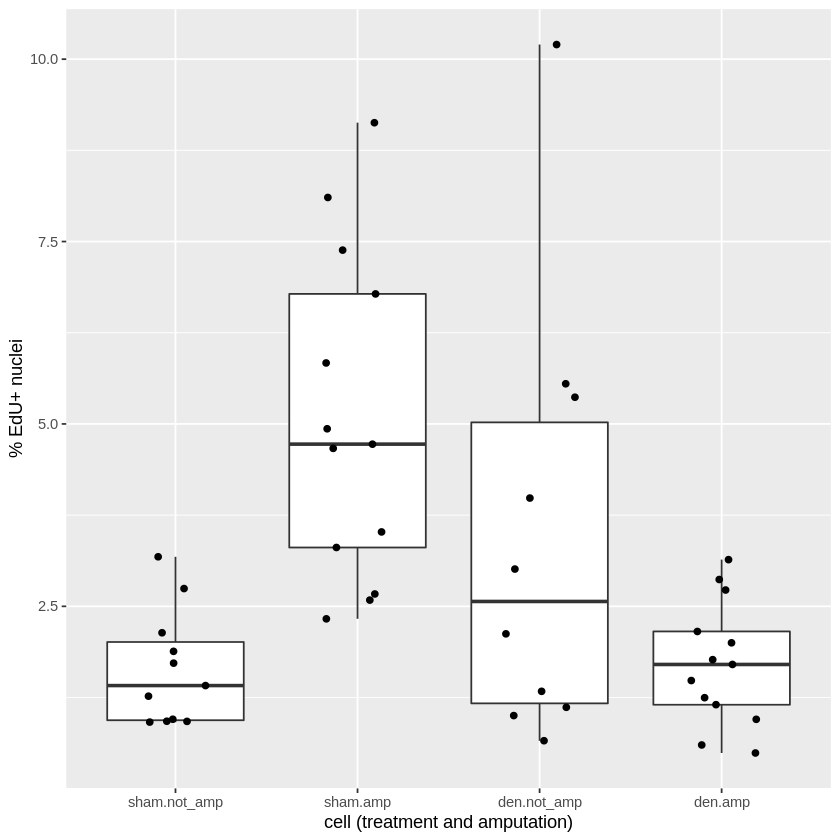

In [ ]:
# Basic data visualization
systemicActivationData3 %>% 
        ggplot(aes(y=y, x=cell)) +
        geom_boxplot()+
        geom_jitter(width = 0.2) +
        labs(y='% EdU+ nuclei', x='cell (treatment and amputation)')

### Test for normality

Run Shapiro-Wilks test to test for normality of the data in each of the 4 cells of the 2-by-2 two-factor design. Significance is determined at the 0.05 level with Bonferroni correction to control for the Family-Wise Error rate (FWER).

In [ ]:
# Run Shapiro-Wilks test
alpha = 0.05
systemicActivationData3 %>%
  select(y, cell) %>%
  group_by(cell) %>%
  mutate(z_score=(y-mean(y))/sd(y)) %>%
  shapiro_test(z_score) %>%
  mutate(significant_bonferroni=(p<alpha/length(unique(systemicActivationData3$cell))))

cell,variable,statistic,p,significant_bonferroni
<ord>,<chr>,<dbl>,<dbl>,<lgl>
sham.not_amp,z_score,0.8737135,0.08650877,FALSE
sham.amp,z_score,0.9349217,0.39458014,FALSE
den.not_amp,z_score,0.8536424,0.06417580,FALSE
den.amp,z_score,0.9615162,0.77689717,FALSE


We conclude that the homogeneity of variance property does not hold in this 2-by-2 two-way factor design.

### Test for homogeneity of variances

Run Levene's test (at the 0.05 level) to test for homogeneity of variances between the 4 cells of the 2-by-2 two-factor design.

In [ ]:
# Run Levene's test
levene = leveneTest(y~cell, data=systemicActivationData3, center=mean)
print(levene)

Levene's Test for Homogeneity of Variance (center = mean)
      Df F value    Pr(>F)    
group  3  6.7676 0.0007716 ***
      43                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


We conclude that the homogeneity of variances property does not hold in this 2-by-2 two-way factor design.

### James-Welch test (omnibus null)

We perform the omnibus James-Welch test (robust 2-way ANOVA), which is protected against unequal variances (by using corrected degrees of freedom when estimating cell standard deviations). Note that this test can also be protected against non-normality using trimming, but we will not use this here since the data passed the Shapiro-Wilks test.

In [ ]:
# Run James-Welch test for the omnibus null
omnibus_JW = welchADF.test(systemicActivationData3, response="y", between.s=c("treatment", "condition"), 
                           contrast = "omnibus", trimming=FALSE, alpha=0.05)
summary(omnibus_JW)

Call:
   welchADF.test(formula = systemicActivationData3, response = "y", 
    between.s = c("treatment", "condition"), contrast = "omnibus", 
    trimming = FALSE, alpha = 0.05)

                    WJ statistic Numerator DF Denominator DF   Pr(>WJ)    
treatment                  1.783            1          19.05 0.1975445    
condition                  2.125            1          19.05 0.1612111    
treatment:condition       19.258            1          19.05 0.0003141 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

We conclude that there is no significant difference in the means for the treatment and condition main effects, but there is a significant interaction effect. 

Note that since we are only in a 2-by-2 two-way design, there is only one interaction pairwise comparison to make (den:sham x amp:not_amp), so we do not need to implement a post-hoc James-Welch test for the interaction.

To conclude, this analysis reveals that the effect of amputation on the response is significantly different depending on whether the subject is denervated or sham-operated.

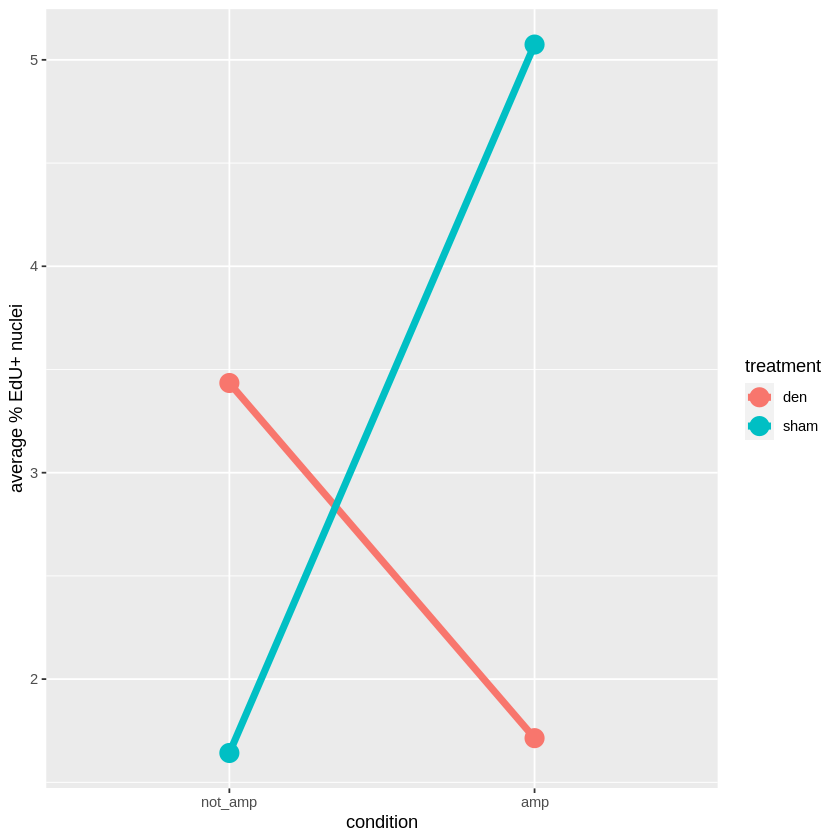

In [ ]:
# Visualize interaction
systemicActivationData3 %>%
  group_by(treatment, condition) %>%
  summarise(mu=mean(y), .groups='drop') %>%
  group_by(treatment) %>%
  ggplot(aes(x=relevel(condition, 'not_amp'), y=mu, color=treatment))+
  geom_line(aes(group = treatment), size=2)+
  geom_point(size=5)+
  labs(y='average % EdU+ nuclei', x='condition')